In [27]:
import os, re, pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [69]:
import matplotlib

In [67]:
pd.__version__

'1.2.4'

In [68]:
np.__version__

'1.19.2'

In [70]:
matplotlib.__version__

'3.1.1'

In [71]:
sns.__version__

'0.9.0'

In [73]:
import nltk
nltk.__version__

'3.4.4'

In [75]:
import sklearn
sklearn.__version__

'0.22.2.post1'

In [3]:
DATA_PATH = "../data"

In [4]:
train_data, train_label = pickle.load(open(os.path.join(DATA_PATH, "training.res"), "rb"))
test_data, test_label = pickle.load(open(os.path.join(DATA_PATH, "testing.res"), "rb"))

In [6]:
d_train = pd.DataFrame(data={'text': train_data, 'label': train_label})
d_test = pd.DataFrame(data={'text': test_data, 'label': test_label})

In [7]:
d_train.head()

,text,label
0,Halo\n blibli. Sedikit saran untuk gratis ong...,Rated 4 stars out of five stars
1,So far so good. Respon cepat.,Rated 5 stars out of five stars
2,thank,Rated 3 stars out of five stars
3,Aplikasi sering not responding di hp saya (as...,Rated 2 stars out of five stars
4,Gak ada komentar.,Rated 5 stars out of five stars


In [8]:
d_test.head()

,text,label
0,bagussss,Rated 5 stars out of five stars
1,Pengiriman gratis dan produk bervariasi,Rated 5 stars out of five stars
2,Praktis dan mudah aplikasinya digunakan,Rated 5 stars out of five stars
3,No comment,Rated 2 stars out of five stars
4,Aplikasi Belanja Online terbaik di Indonesia ...,Rated 5 stars out of five stars


In [9]:
d_train.shape

(7028, 2)

In [10]:
d_test.shape

(3012, 2)

### Parsing Label

This section for parsing label to number

In [15]:
d_train['label_num'] = d_train.label.apply(lambda label: re.search("\d", label).group()).astype(int)
d_test['label_num'] = d_test.label.apply(lambda label: re.search("\d", label).group()).astype(int)

In [19]:
d_train['sentiment'] = (d_train.label_num > 3).astype(int)
d_test['sentiment'] = (d_test.label_num > 3).astype(int)

In [21]:
d_train.head()

,text,label,label_num,sentiment
0,Halo\n blibli. Sedikit saran untuk gratis ong...,Rated 4 stars out of five stars,4,1
1,So far so good. Respon cepat.,Rated 5 stars out of five stars,5,1
2,thank,Rated 3 stars out of five stars,3,0
3,Aplikasi sering not responding di hp saya (as...,Rated 2 stars out of five stars,2,0
4,Gak ada komentar.,Rated 5 stars out of five stars,5,1


In [23]:
d_test.head()

,text,label,label_num,sentiment
0,bagussss,Rated 5 stars out of five stars,5,1
1,Pengiriman gratis dan produk bervariasi,Rated 5 stars out of five stars,5,1
2,Praktis dan mudah aplikasinya digunakan,Rated 5 stars out of five stars,5,1
3,No comment,Rated 2 stars out of five stars,2,0
4,Aplikasi Belanja Online terbaik di Indonesia ...,Rated 5 stars out of five stars,5,1


### Text preprocessing

In [28]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

In [29]:
def preprocess_text(text):
    text = text.lower()
    
    # stemming process
    text   = stemmer.stem(text)
    
    return text

In [30]:
d_train['text_clean'] = d_train.text.apply(preprocess_text)

In [48]:
d_test['text_clean'] = d_test.text.apply(preprocess_text)

In [32]:
d_train.head()

,text,label,label_num,sentiment,text_clean
0,Halo\n blibli. Sedikit saran untuk gratis ong...,Rated 4 stars out of five stars,4,1,halo blibli sedikit saran untuk gratis ongkirn...
1,So far so good. Respon cepat.,Rated 5 stars out of five stars,5,1,so far so good respon cepat
2,thank,Rated 3 stars out of five stars,3,0,thank
3,Aplikasi sering not responding di hp saya (as...,Rated 2 stars out of five stars,2,0,aplikasi sering not responding di hp saya asus...
4,Gak ada komentar.,Rated 5 stars out of five stars,5,1,gak ada komentar


In [49]:
d_test.head()

,text,label,label_num,sentiment,text_clean
0,bagussss,Rated 5 stars out of five stars,5,1,bagussss
1,Pengiriman gratis dan produk bervariasi,Rated 5 stars out of five stars,5,1,kirim gratis dan produk variasi
2,Praktis dan mudah aplikasinya digunakan,Rated 5 stars out of five stars,5,1,praktis dan mudah aplikasi guna
3,No comment,Rated 2 stars out of five stars,2,0,no comment
4,Aplikasi Belanja Online terbaik di Indonesia ...,Rated 5 stars out of five stars,5,1,aplikasi belanja online baik di indonesia saat...


### Feature extraction

In [33]:
tfidf = TfidfVectorizer()

In [34]:
X_train = tfidf.fit_transform(d_train.text_clean)

In [50]:
X_test = tfidf.transform(d_test.text_clean)

In [51]:
X_train.shape

(7028, 5467)

In [52]:
X_test.shape

(3012, 5467)

### Model

In [56]:
model = SVC(C=1.0, kernel='linear', random_state=42)

In [57]:
model

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [58]:
model.fit(X_train, d_train.sentiment)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [59]:
y_pred = model.predict(X_test)

In [60]:
def scoring(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    return {'accuracy': acc, 'recall': rec , 'precision': pre, 'f score': f1}

In [61]:
scoring(d_test.sentiment, y_pred)

{'accuracy': 0.9189907038512616,
 'recall': 0.9687993680884676,
 'precision': 0.9369747899159664,
 'f score': 0.9526213592233008}

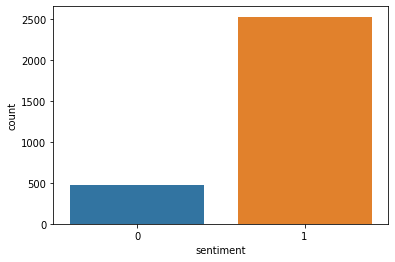

In [64]:
sns.countplot(d_test.sentiment)

In [65]:
d_test.sentiment.value_counts()

1    2532
0     480
Name: sentiment, dtype: int64

In [66]:
2532 / d_test.shape[0]

0.8406374501992032